# Los Angeles Metro COVID-19 Recovery

In [1]:
import altair
import contextily
import pandas
import geopandas

In [2]:
bus_ridership = pandas.read_parquet("metro-bus-covid-recovery.parquet")
bus_lines = geopandas.read_file("https://developer.metro.net/wp-content/uploads/2021/02/All0620.zip")

In [3]:
top_bus_lines = (
    bus_ridership.groupby("line")
    .ridership_2019
    .mean()
    .sort_values(ascending=False)
    .head(30)
)
top_bus_lines

line
720        28362.583333
51         23427.333333
901        21634.000000
16         20841.583333
754        20183.750000
204        20162.833333
45/745     19962.166667
60/760     18786.333333
18         17574.750000
910        17554.416667
14         16671.916667
210/710    16576.000000
207        16152.750000
40/740     16143.333333
105/705    15513.000000
108        14971.166667
111        14858.083333
4          14543.083333
115        13982.583333
28/728     13953.416667
81         13297.583333
260/762    13182.166667
20         12803.833333
251/751    12445.166667
757        11893.250000
30         11879.666667
2          11796.250000
53         11575.454545
10         11441.750000
200        11090.333333
Name: ridership_2019, dtype: float64

In [4]:
bus_ridership = bus_ridership.assign(
    recovery=bus_ridership.ridership/bus_ridership.ridership_2019
)

In [5]:
chart = (
    altair.Chart(
        bus_ridership[bus_ridership.line.isin(top_bus_lines.index)],
        width=1024,
        height=512,
        title="Metro bus ridership recovery",
    )
    .mark_line()
    .encode(
        x=altair.X("date:T", title="Date"),
        y=altair.Y("recovery:Q", title="Fraction of 2019 weekday ridership"),
        color=altair.Color("line:N", title="Line"),
    )
)

tooltip = chart.mark_point(
    size=100, opacity=0,
).encode(
    tooltip=[
        altair.Tooltip("line:N", title="Line"),
        altair.Tooltip("recovery:Q", title="Fraction of 2019 weekday ridership"),
    ]
)
figure = (chart + tooltip)
figure

alt.LayerChart(...)

In [6]:
import altair_saver
altair_saver.save(figure, "metro-recovery-chart.html")

In [7]:
bus_ridership_recovery = (
    bus_ridership[bus_ridership.date == bus_ridership.date.max()]
    .sort_values("recovery", ascending=False)
)

In [8]:
display({"text/markdown": "## Recovery of high-ridership (pre-COVID-19) lines"}, raw=True)
bus_ridership_recovery.sort_values(
    "ridership_2019", ascending=False
).head(30).sort_values(
    "recovery", ascending=False
).drop(columns=["date", "ridership_2018"]).style.hide_index()

## Recovery of high-ridership (pre-COVID-19) lines

line,ridership,ridership_2019,recovery
18,11909.000000,17574.750000,0.677620
207,10755.000000,16152.750000,0.665831
204,12589.000000,20162.833333,0.624367
105/705,9378.000000,15513.000000,0.604525
251/751,7516.000000,12445.166667,0.603929
4,8673.000000,14543.083333,0.596366
51,13875.000000,23427.333333,0.592257
40/740,9069.000000,16143.333333,0.561780
111,8276.000000,14858.083333,0.557003
16,11532.000000,20841.583333,0.553317


In [9]:
display({"text/markdown": "## Most recovered lines"}, raw=True)
display(bus_ridership_recovery.head(20).drop(columns=["date"]).style.hide_index())
display({"text/markdown": "## Least recovered lines"}, raw=True)
display(bus_ridership_recovery.tail(20).drop(columns=["date"]).style.hide_index())

## Most recovered lines

line,ridership,ridership_2019,ridership_2018,recovery
66,8439.000000,10711.666667,11083.833333,0.787833
611,1172.000000,1503.833333,1535.916667,0.779342
94,3127.000000,4210.916667,4430.666667,0.742594
233,7952.000000,11047.833333,11521.750000,0.719779
180,5568.000000,7962.833333,7966.500000,0.699249
603,4924.000000,7095.750000,7035.583333,0.693937
18,11909.000000,17574.750000,17755.000000,0.677620
207,10755.000000,16152.750000,16686.250000,0.665831
204,12589.000000,20162.833333,21155.500000,0.624367
744,5112.000000,8376.166667,8452.416667,0.610303


## Least recovered lines

line,ridership,ridership_2019,ridership_2018,recovery
605,749.000000,2128.833333,2148.500000,0.351836
211,205.000000,583.833333,627.916667,0.351128
252,703.000000,2089.000000,1948.583333,0.336525
687,390.000000,1178.583333,1238.583333,0.330906
577,278.000000,874.666667,760.166667,0.317835
209,249.000000,794.000000,735.750000,0.313602
236,483.000000,1560.750000,1609.916667,0.309467
245,754.000000,2540.000000,2559.500000,0.296850
601,281.000000,975.833333,1021.333333,0.287959
258,711.000000,2583.666667,2524.333333,0.275190


In [10]:
metro_lines_recovery = bus_lines.merge(
    bus_ridership_recovery,
    left_on="VAR_ROUTE",
    right_on="line",
    how="inner"
)

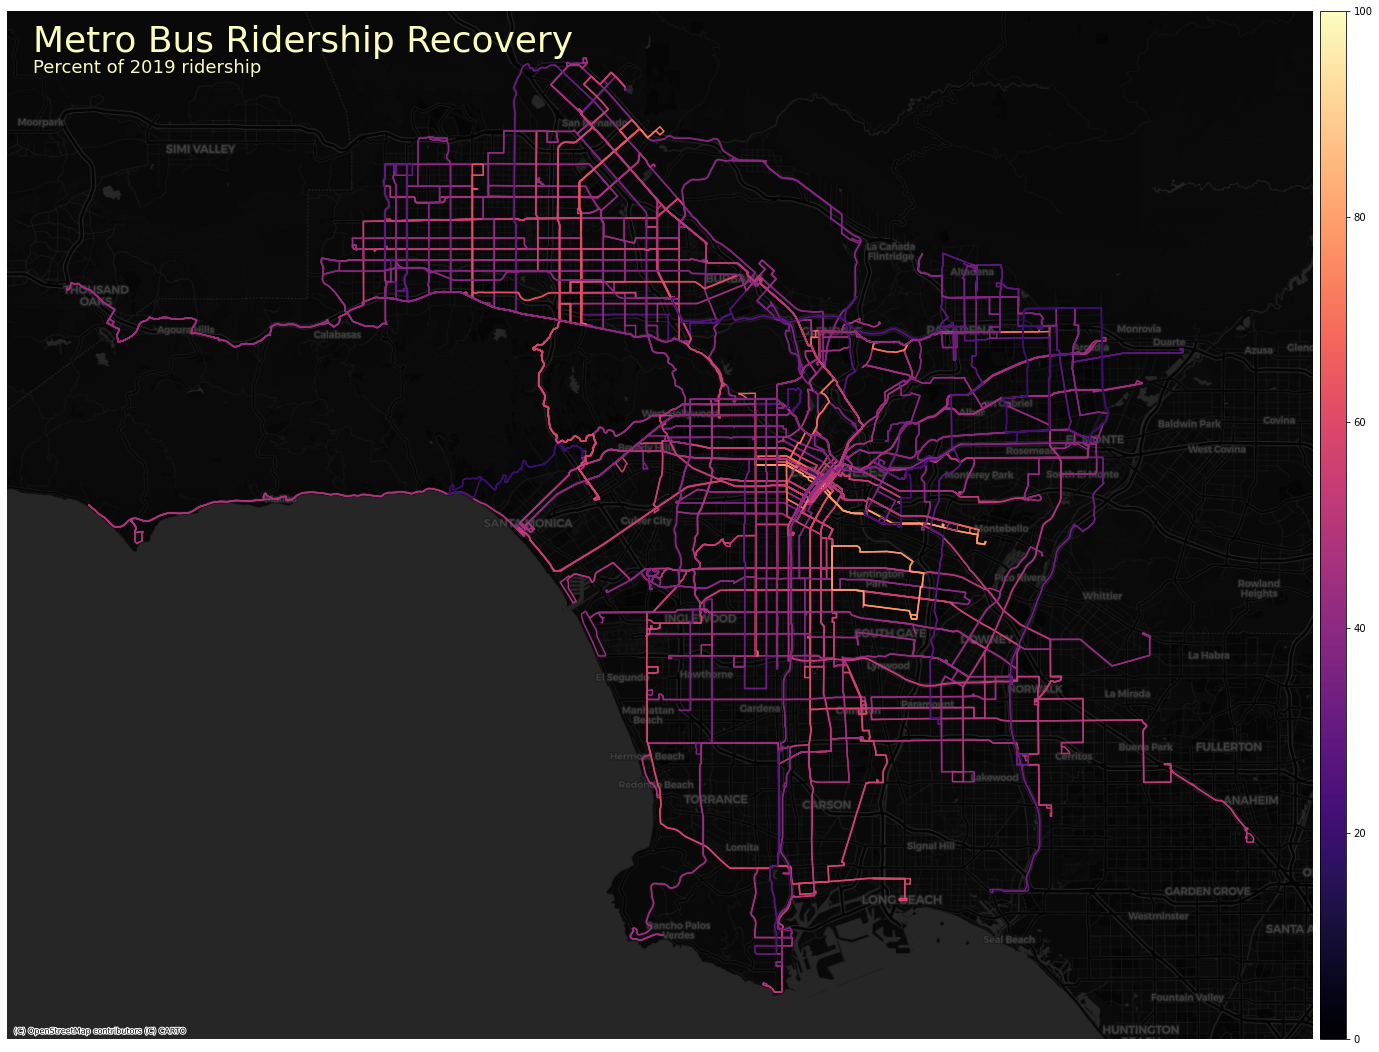

In [11]:
# Plot population estimates with an accurate legend
import matplotlib.pyplot as plt

cmap = plt.get_cmap("magma")
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(24,24))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

metro_lines_recovery.to_crs(epsg=3857).plot(
    figsize=(24,24),
    cmap=cmap,
    column=metro_lines_recovery.recovery * 100.,
    legend=True,
    ax=ax,
    cax=cax,
    vmin =0.0,
    vmax=100.0,
)
contextily.add_basemap(ax, source=contextily.providers.CartoDB.DarkMatter)
ax.text(0.02, 0.96,"Metro Bus Ridership Recovery", color=cmap(1.0), fontsize=36, transform=ax.transAxes)
ax.text(0.02, 0.94,"Percent of 2019 ridership", color=cmap(1.0), fontsize=18, transform=ax.transAxes)
ax.set_axis_off()

plt.close()
fig.savefig("metro-recovery-map.png")
fig